C:\CODE\Torch\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Đang chuyển đổi sang Spectrogram (Lưu vào ổ cứng để chống tràn RAM)...


Map: 100%|██████████| 1700/1700 [01:12<00:00, 23.41 examples/s]
Parameter 'function'=<function preprocess_function at 0x000002AC73E32050> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only shown once. Subsequent hashing failures won't be shown.
Map: 100%|██████████| 300/300 [00:07<00:00, 38.36 examples/s]
Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([50]) in the model instantiated
- classifier.dense.weight:

🧹 Đang dọn sạch RAM và VRAM...
🚀 Bắt đầu huấn luyện (Dự kiến chạy chậm hơn nhưng KHÔNG CRASH)...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.559200,0.508295,0.846667
2,0.163600,0.256703,0.920000
3,0.006200,0.129283,0.970000


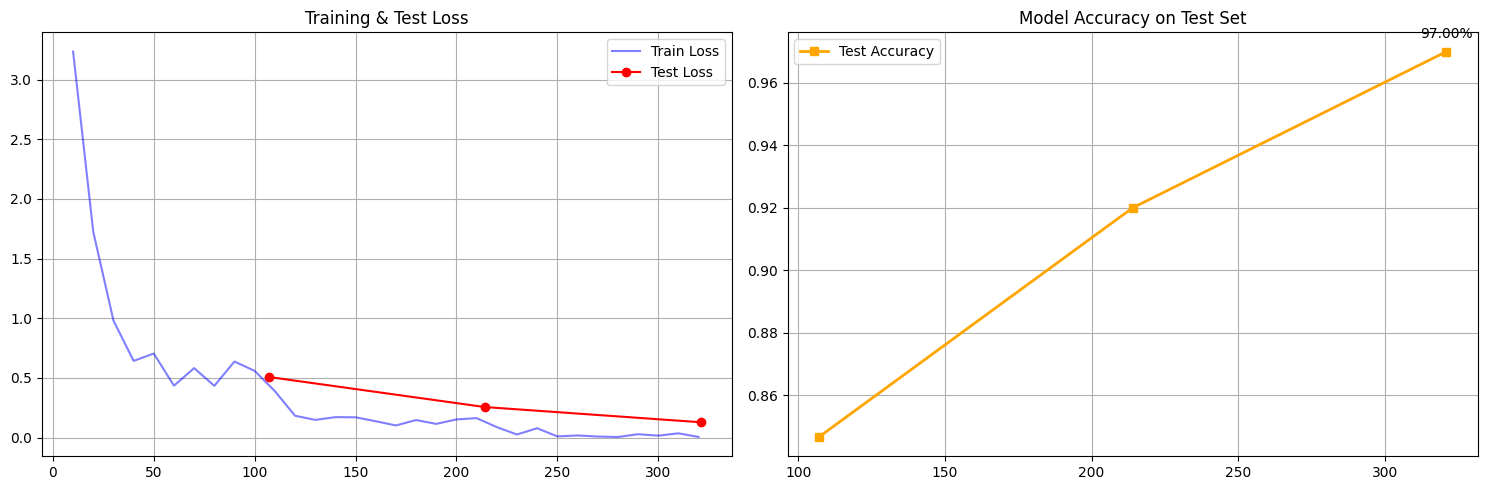

✅ Hoàn thành! Model đã nằm tại: C:\CODE\ast_esc50_final_model


In [ ]:
import os
import sys
# --- 1. CẤU HÌNH MÔI TRƯỜNG ---
TORCH_LIB = r"C:\CODE\Torch"
if TORCH_LIB not in sys.path:
    sys.path.insert(0, TORCH_LIB)
    
import gc
import pandas as pd
import numpy as np
import torch
import librosa
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score



os.environ['HF_HOME'] = r"C:\CODE\huggingface_cache"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# --- 2. CHUẨN BỊ DỮ LIỆU ---
AUDIO_DIR = r"C:\CODE\Python\DeepLearning\AudioDemo\uploads"
LABEL_CSV = r"C:\CODE\Python\DeepLearning\esc50.csv"

df = pd.read_csv(LABEL_CSV)
df['audio_path'] = df['filename'].apply(lambda x: os.path.join(AUDIO_DIR, x))
unique_labels = sorted(df['category'].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for i, label in enumerate(unique_labels)}
df['label'] = df['category'].map(label2id)

dataset = Dataset.from_pandas(df[['audio_path', 'label']])
dataset = dataset.train_test_split(test_size=0.15, seed=42)

# --- 3. TIỀN XỬ LÝ (TỐI ƯU RAM HỆ THỐNG) ---
model_id = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_id)

def preprocess_function(examples):
    audio_arrays = []
    for path in examples["audio_path"]:
        speech, _ = librosa.load(path, sr=16000)
        audio_arrays.append(speech)
    return feature_extractor(audio_arrays, sampling_rate=16000, return_tensors="pt", padding=True)

print("🔄 Đang chuyển đổi sang Spectrogram (Lưu vào ổ cứng để chống tràn RAM)...")
encoded_dataset = dataset.map(
    preprocess_function, 
    batched=True, 
    batch_size=8,             # Chia nhỏ batch khi map
    remove_columns=["audio_path"],
    keep_in_memory=False      # QUAN TRỌNG: Đẩy dữ liệu xuống ổ đĩa C
)

# --- 4. KHỞI TẠO MODEL ---
model = AutoModelForAudioClassification.from_pretrained(
    model_id, num_labels=50, label2id=label2id, id2label=id2label, ignore_mismatched_sizes=True
)

# --- 5. CẤU HÌNH TRAIN (CHẾ ĐỘ SIÊU AN TOÀN - CHỐNG CRASH) ---
training_args = TrainingArguments(
    output_dir=r"C:\CODE\ast_fast_results",
    
    # Chiến thuật chia nhỏ cực hạn
    per_device_train_batch_size=1,      # Chỉ nạp 1 mẫu vào GPU (Chống tràn VRAM)
    per_device_eval_batch_size=1,       # Khi đánh giá cũng nạp 1 mẫu (Chống sập Epoch)
    gradient_accumulation_steps=16,     # Tăng lên 16: Tổng Batch thực tế = 16 mẫu 
                                        # Giúp đạt mốc 96% mà không tốn RAM
    
    num_train_epochs=3,
    learning_rate=1e-4,
    fp16=True,                          # Tính toán 16-bit (Giảm 50% bộ nhớ GPU)
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=10,                   # Hiện log thường xuyên hơn
    
    group_by_length=False,              
    dataloader_num_workers=0,           # Tránh lỗi luồng trên Windows
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    
    gradient_checkpointing=True         # Đánh đổi tốc độ lấy thêm bộ nhớ
)

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return {"accuracy": accuracy_score(eval_pred.label_ids, predictions)}

# --- 6. KHỞI TẠO TRAINER ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    compute_metrics=compute_metrics,
)

# --- 7. DỌN DẸP TRIỆT ĐỂ VÀ TRAIN ---
print("🧹 Đang dọn sạch RAM và VRAM...")
if 'df' in locals(): del df
if 'dataset' in locals(): del dataset
gc.collect()
torch.cuda.empty_cache()

print("🚀 Bắt đầu huấn luyện (Dự kiến chạy chậm hơn nhưng KHÔNG CRASH)...")
trainer.train()

# --- 8. LƯU MÔ HÌNH ---
SAVE_DIR = r"C:\CODE\ast_esc50_final_model"
model.save_pretrained(SAVE_DIR)
feature_extractor.save_pretrained(SAVE_DIR)

# --- 9. VẼ BIỂU ĐỒ ---
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
train_steps = [x['step'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
eval_steps = [x['step'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Train Loss', alpha=0.5, color='blue')
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Test Loss', marker='o', color='red')
plt.title('Training & Test Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
if eval_acc:
    plt.plot(eval_steps, eval_acc, label='Test Accuracy', color='orange', marker='s', linewidth=2)
    # Hiển thị số Accuracy cuối cùng
    plt.annotate(f"{eval_acc[-1]:.2%}", (eval_steps[-1], eval_acc[-1]), textcoords="offset points", xytext=(0,10), ha='center')
plt.title('Model Accuracy on Test Set')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"✅ Hoàn thành! Model đã nằm tại: {SAVE_DIR}")

🎨 Bắt đầu khởi tạo các biểu đồ báo cáo...


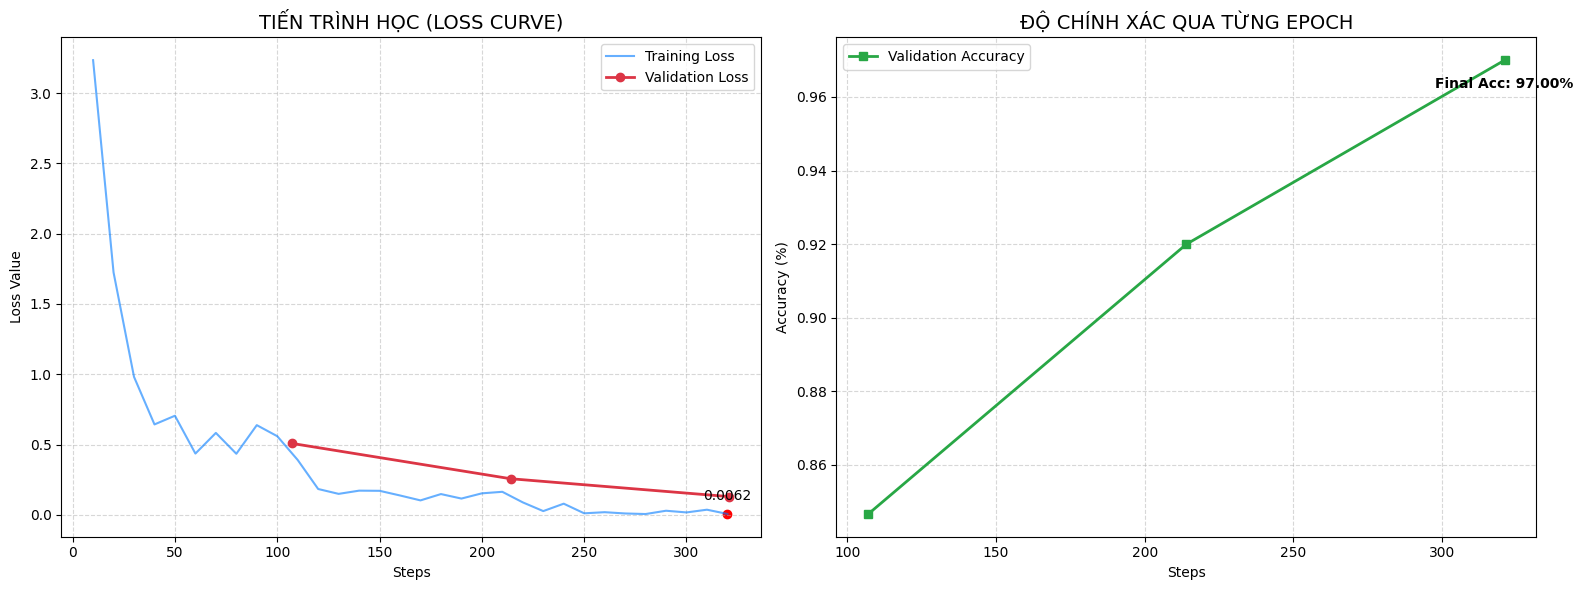

📊 Đang thực hiện dự đoán trên tập Test để lập Ma trận nhầm lẫn...


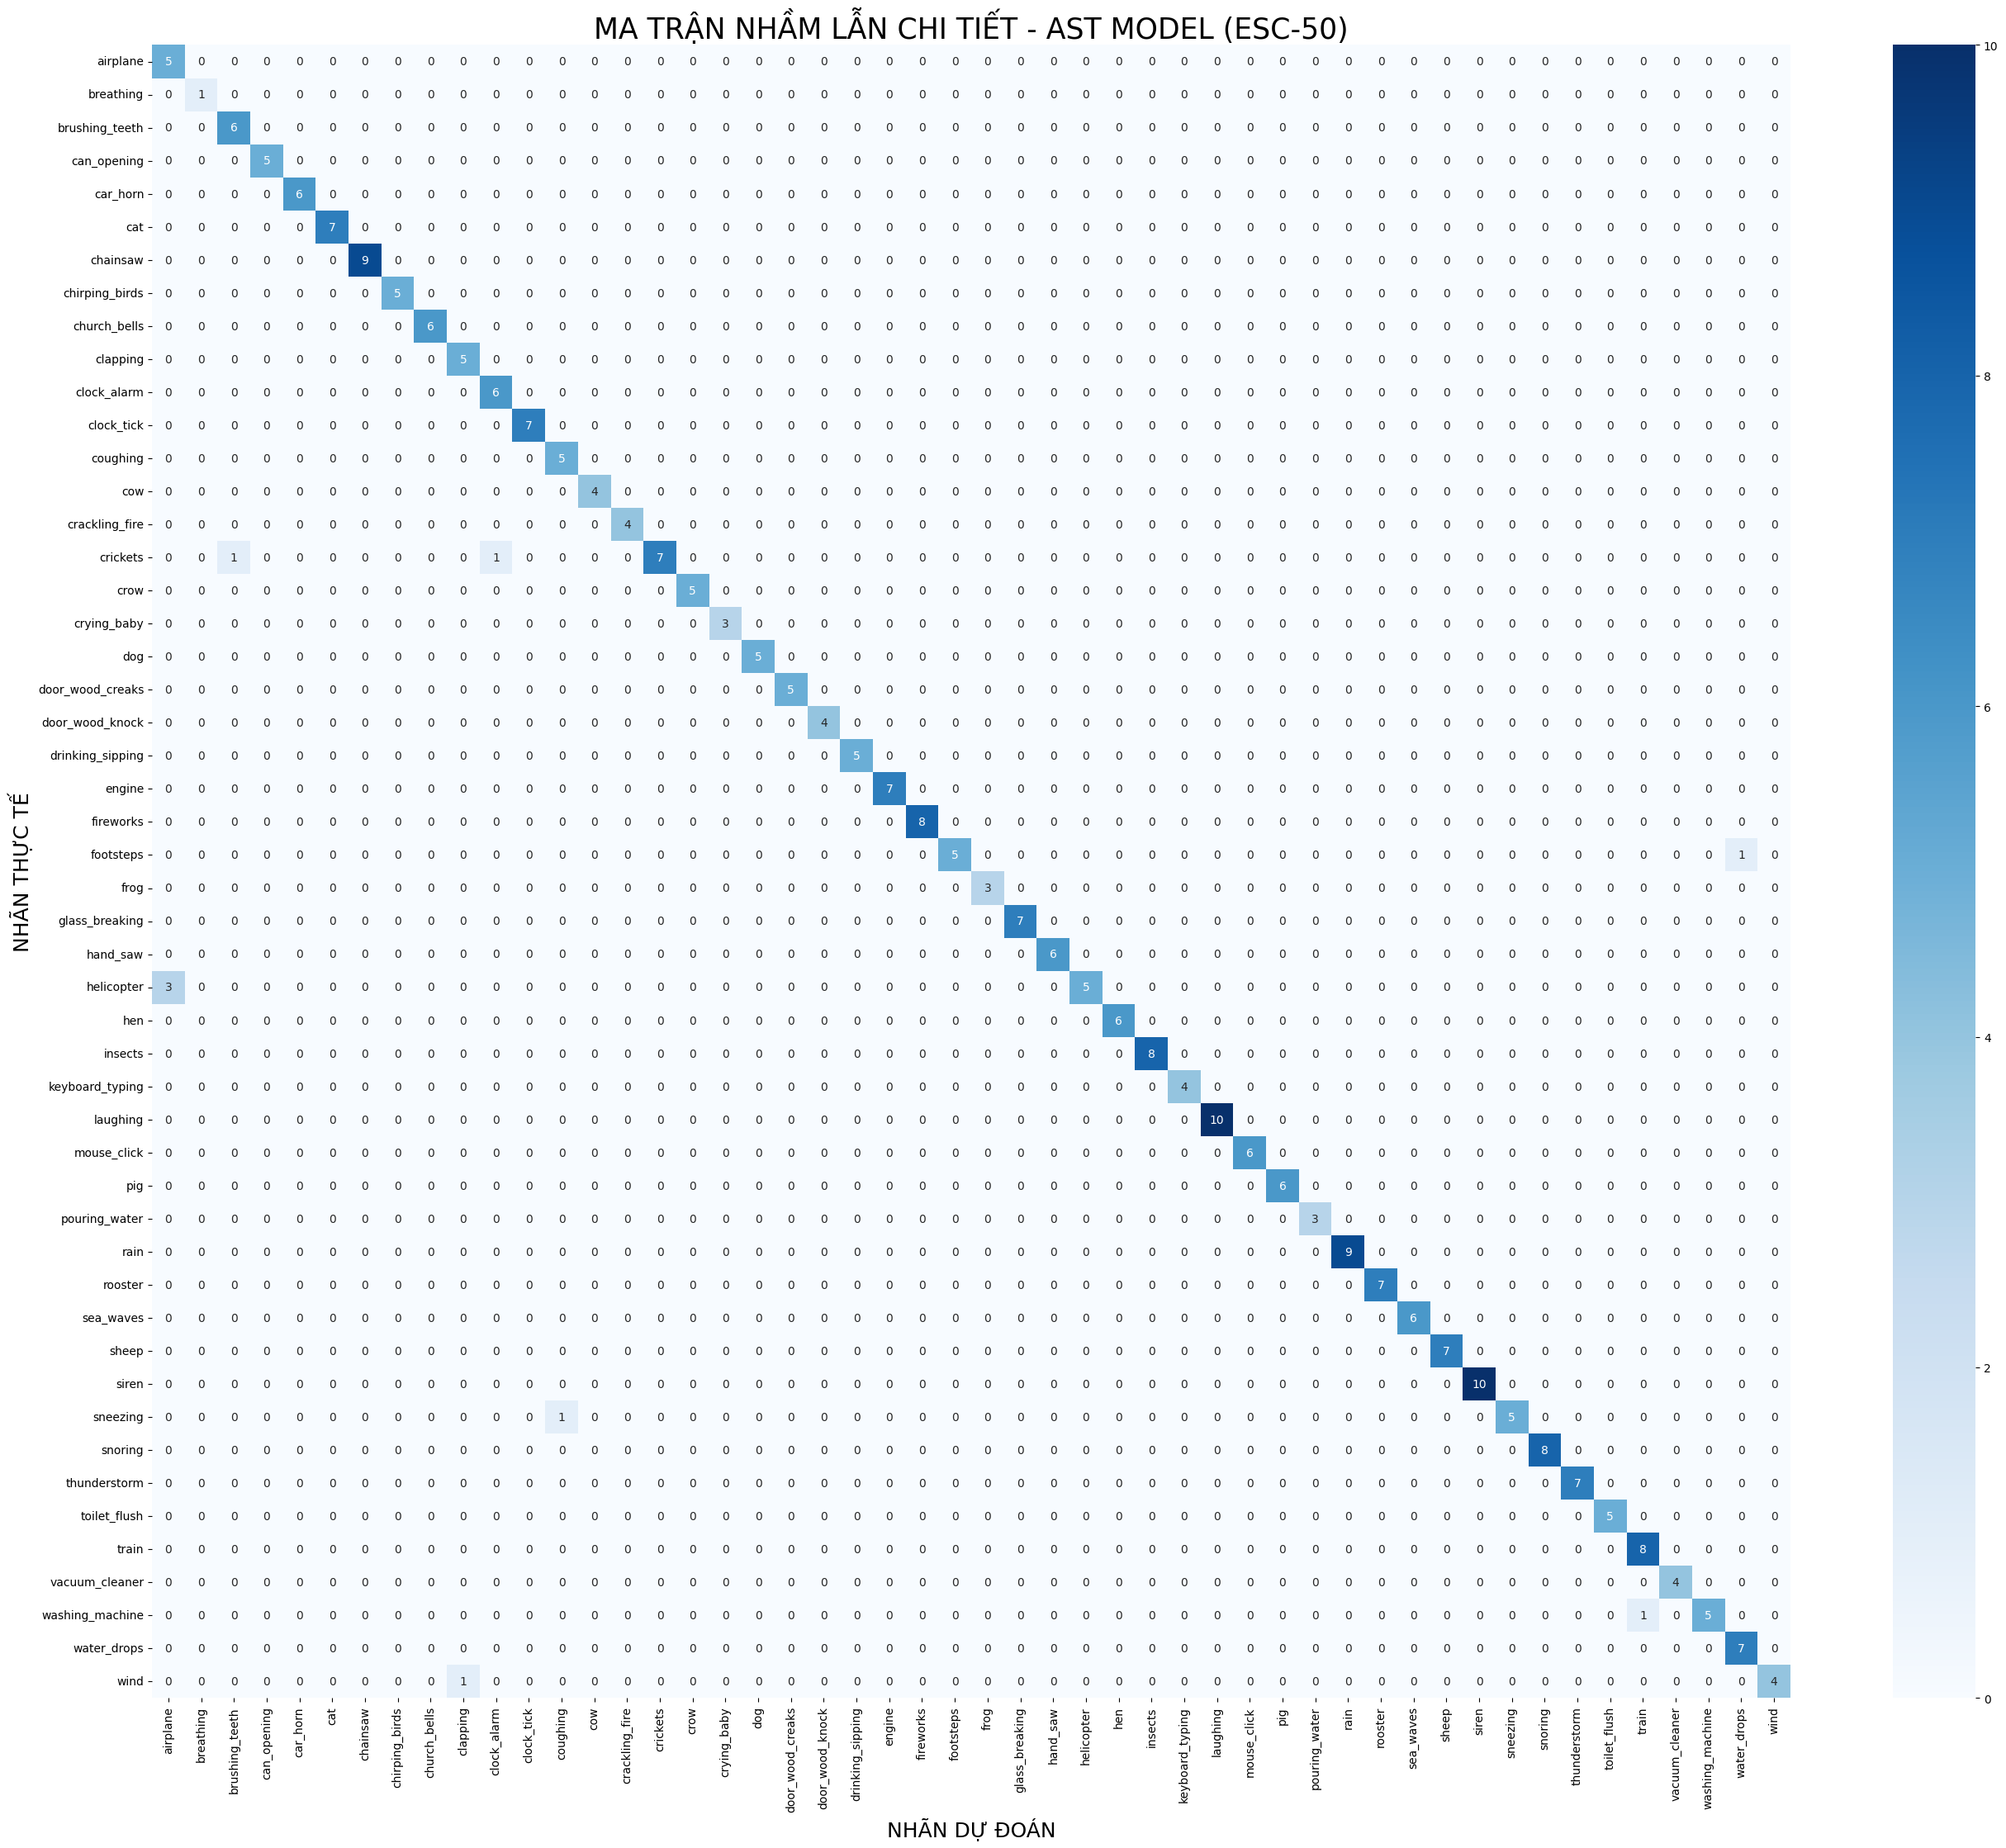

🖼️ Đang vẽ minh họa Spectrogram thực tế...


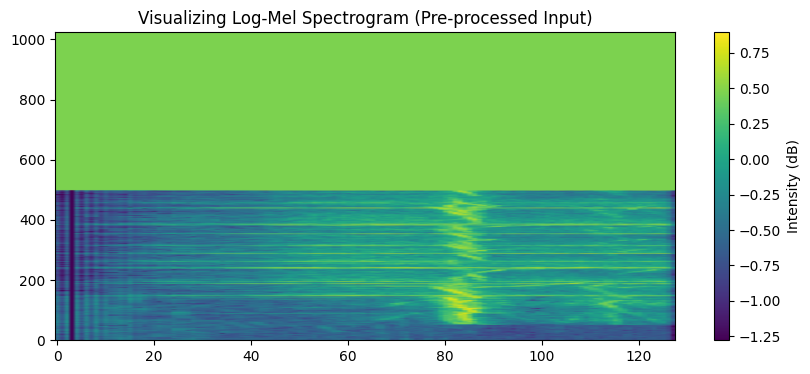


📋 BÁO CÁO PHÂN LOẠI CHI TIẾT:

                  precision    recall  f1-score   support

        airplane       0.62      1.00      0.77         5
       breathing       1.00      1.00      1.00         1
  brushing_teeth       0.86      1.00      0.92         6
     can_opening       1.00      1.00      1.00         5
        car_horn       1.00      1.00      1.00         6
             cat       1.00      1.00      1.00         7
        chainsaw       1.00      1.00      1.00         9
  chirping_birds       1.00      1.00      1.00         5
    church_bells       1.00      1.00      1.00         6
        clapping       0.83      1.00      0.91         5
     clock_alarm       0.86      1.00      0.92         6
      clock_tick       1.00      1.00      1.00         7
        coughing       0.83      1.00      0.91         5
             cow       1.00      1.00      1.00         4
  crackling_fire       1.00      1.00      1.00         4
        crickets       1.00      0.78  

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- CẤU HÌNH LƯU TRỮ ---
# Sử dụng MODEL_PATH đã định nghĩa ở phần trước hoặc tạo mới
SAVE_PATH = r"C:\CODE\ast_esc50_final_model"
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

print("🎨 Bắt đầu khởi tạo các biểu đồ báo cáo...")

# --- 1. VẼ BIỂU ĐỒ TIẾN TRÌNH HỌC (LOSS & ACCURACY CURVES) ---
history = trainer.state.log_history

# Trích xuất dữ liệu từ log
train_loss = [x['loss'] for x in history if 'loss' in x]
train_steps = [x['step'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
eval_steps = [x['step'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(16, 6))

# Subplot 1: Loss (Train vs Validation)
plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss, label='Training Loss', color='#007bff', alpha=0.6)
if eval_loss:
    plt.plot(eval_steps, eval_loss, label='Validation Loss', color='#dc3545', marker='o', linewidth=2)
    # Đánh dấu điểm Loss cuối cùng
    plt.scatter(train_steps[-1], train_loss[-1], color='red')
    plt.annotate(f"{train_loss[-1]:.4f}", (train_steps[-1], train_loss[-1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('TIẾN TRÌNH HỌC (LOSS CURVE)', fontsize=14)
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Subplot 2: Accuracy (Validation)
plt.subplot(1, 2, 2)
if eval_acc:
    plt.plot(eval_steps, eval_acc, label='Validation Accuracy', color='#28a745', marker='s', linewidth=2)
    # Đánh dấu điểm Accuracy cuối cùng
    final_acc = eval_acc[-1] * 100
    plt.annotate(f"Final Acc: {final_acc:.2f}%", (eval_steps[-1], eval_acc[-1]), textcoords="offset points", xytext=(0,-20), ha='center', fontweight='bold')

plt.title('ĐỘ CHÍNH XÁC QUA TỪNG EPOCH', fontsize=14)
plt.xlabel('Steps')
plt.ylabel('Accuracy (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(SAVE_PATH, "learning_progress.png"), dpi=300)
plt.show()

# --- 2. DỰ ĐOÁN VÀ VẼ MA TRẬN NHẦM LẪN (CONFUSION MATRIX) KHỔ LỚN ---
print("📊 Đang thực hiện dự đoán trên tập Test để lập Ma trận nhầm lẫn...")
# Tận dụng trainer.predict để lấy kết quả nhanh và chính xác nhất
predictions_output = trainer.predict(encoded_dataset["test"])
all_preds = np.argmax(predictions_output.predictions, axis=1)
all_labels = predictions_output.label_ids

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(32, 26)) # Kích thước lớn để không bị chồng lấp 50 nhãn
sns.heatmap(
    cm, 
    annot=True,      # Hiển thị số lượng cụ thể vào ô
    fmt='d',         # Định dạng số nguyên
    cmap='Blues', 
    xticklabels=unique_labels, 
    yticklabels=unique_labels,
    annot_kws={"size": 10}
)

plt.title("MA TRẬN NHẦM LẪN CHI TIẾT - AST MODEL (ESC-50)", fontsize=25)
plt.xlabel("NHÃN DỰ ĐOÁN", fontsize=18)
plt.ylabel("NHÃN THỰC TẾ", fontsize=18)
plt.xticks(rotation=90)
plt.savefig(os.path.join(SAVE_PATH, "confusion_matrix_final.png"), dpi=300, bbox_inches='tight')
plt.show()

# --- 3. MINH HỌA SPECTROGRAM ---
print("🖼️ Đang vẽ minh họa Spectrogram thực tế...")
sample_input = encoded_dataset["test"][0]["input_values"]
plt.figure(figsize=(10, 4))
plt.imshow(sample_input, aspect='auto', origin='lower')
plt.title("Visualizing Log-Mel Spectrogram (Pre-processed Input)")
plt.colorbar(label='Intensity (dB)')
plt.savefig(os.path.join(SAVE_PATH, "spectrogram_sample.png"))
plt.show()

# --- 4. XUẤT BÁO CÁO PHÂN LOẠI CHI TIẾT ---
report = classification_report(all_labels, all_preds, target_names=unique_labels)
print("\n📋 BÁO CÁO PHÂN LOẠI CHI TIẾT:\n")
print(report)

# Lưu báo cáo vào file text
with open(os.path.join(SAVE_PATH, "classification_report.txt"), "w", encoding="utf-8") as f:
    f.write(report)

print(f"✅ HOÀN TẤT! Toàn bộ file kết quả đã nằm tại: {SAVE_PATH}")

Resnet - Transformer

Map: 100%|██████████| 300/300 [00:05<00:00, 59.34 examples/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 39.7MB/s]


Epoch 01 | Val Acc: 30.67%
Epoch 02 | Val Acc: 39.67%
Epoch 03 | Val Acc: 52.00%
Epoch 04 | Val Acc: 62.33%
Epoch 05 | Val Acc: 61.67%
Epoch 06 | Val Acc: 68.00%
Epoch 07 | Val Acc: 71.33%
Epoch 08 | Val Acc: 75.33%
Epoch 09 | Val Acc: 76.33%
Epoch 10 | Val Acc: 79.33%


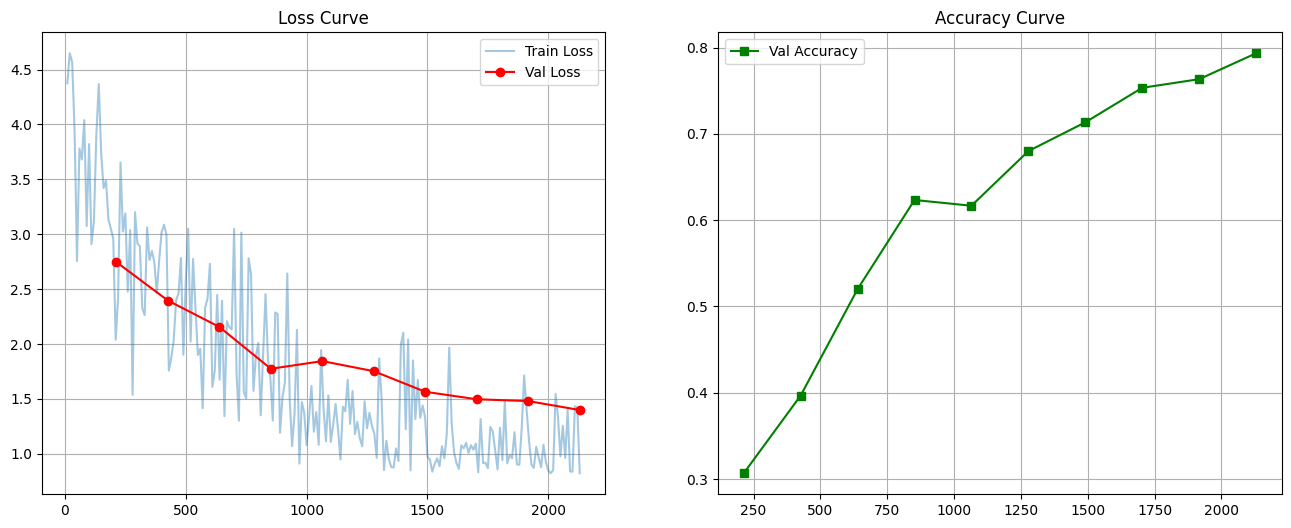

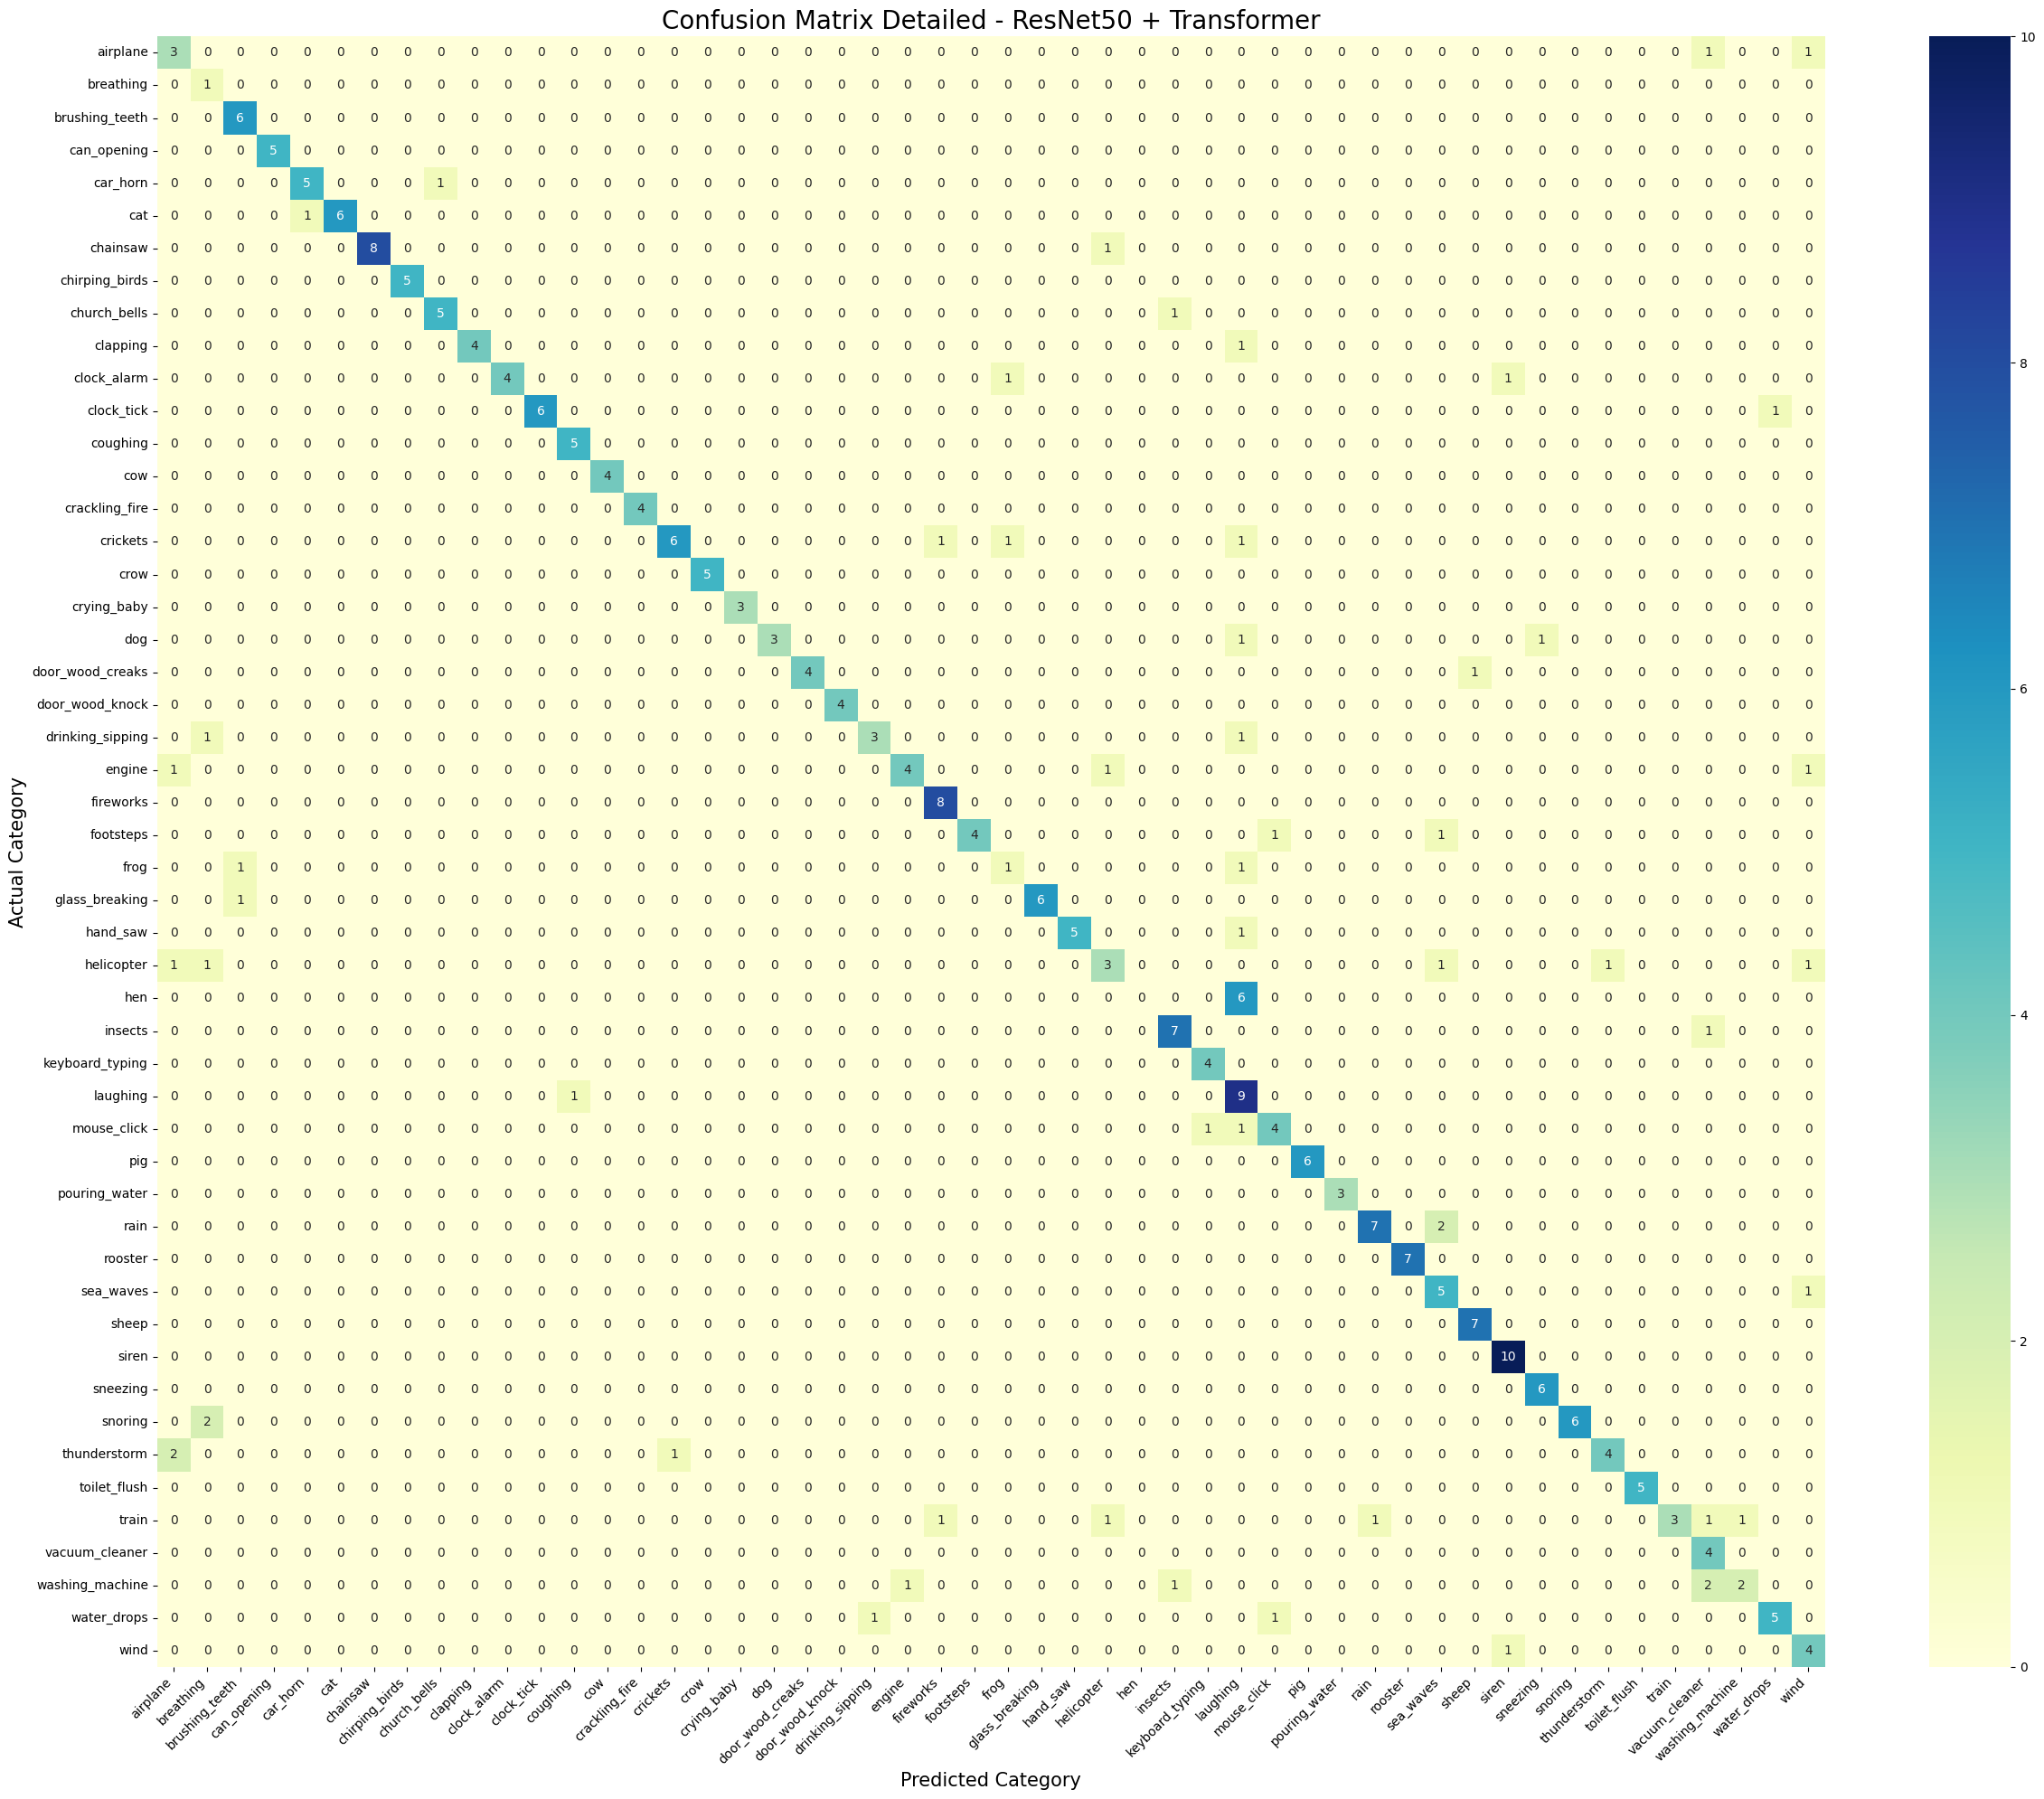

In [3]:
import os
import gc
import sys
TORCH_LIB = r"C:\CODE\Torch"
if TORCH_LIB not in sys.path:
    sys.path.insert(0, TORCH_LIB)
    
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from datasets import Dataset
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# --- 1. CẤU HÌNH ---
os.environ['HF_HOME'] = r"C:\CODE\huggingface_cache"
SAVE_DIR = r"C:\CODE\resnet50_finetune_results"
os.makedirs(SAVE_DIR, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. DATA ---
AUDIO_DIR = r"C:\CODE\Python\DeepLearning\AudioDemo\uploads"
LABEL_CSV = r"C:\CODE\Python\DeepLearning\esc50.csv"

df = pd.read_csv(LABEL_CSV)
df['audio_path'] = df['filename'].apply(lambda x: os.path.join(AUDIO_DIR, x))
unique_labels = sorted(df['category'].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
df['label'] = df['category'].map(label2id)

dataset = Dataset.from_pandas(df[['audio_path', 'label']])
dataset = dataset.train_test_split(test_size=0.15, seed=42)

# --- 3. TIỀN XỬ LÝ ---
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

def preprocess_function(examples):
    audio_arrays = [librosa.load(path, sr=16000)[0] for path in examples["audio_path"]]
    inputs = feature_extractor(audio_arrays, sampling_rate=16000, return_tensors="pt", padding=True)
    return {"pixel_values": inputs["input_values"]}

encoded_dataset = dataset.map(preprocess_function, batched=True, batch_size=8, remove_columns=["audio_path"], keep_in_memory=False)
encoded_dataset.set_format("torch")

# --- 4. KIẾN TRÚC FINE-TUNING (RESNET-50 + TRANSFORMER) ---
class AudioFineTuneModel(nn.Module):
    def __init__(self, num_classes=50):
        super(AudioFineTuneModel, self).__init__()
        # ĐỔI THÀNH RESNET-50
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        
        # Sửa lớp vào cho ảnh phổ 1 kênh
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        ) 
        
        # d_model của ResNet-50 là 2048
        encoder_layer = nn.TransformerEncoderLayer(d_model=2048, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.cnn(x)    # Output shape: [B, 2048, H, W]
        x = x.mean(dim=2).permute(0, 2, 1) # Chuỗi thời gian: [B, W, 2048]
        x = self.transformer(x)
        return self.fc(x.mean(dim=1))

model = AudioFineTuneModel(num_classes=50).to(device)

# --- 5. HUẤN LUYỆN ---
train_loader = DataLoader(encoded_dataset["train"], batch_size=8, shuffle=True)
test_loader = DataLoader(encoded_dataset["test"], batch_size=8)

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
history = {'train_loss': [], 'train_steps': [], 'eval_loss': [], 'eval_acc': [], 'eval_steps': []}

global_step = 0
for epoch in range(10):
    model.train()
    for batch in train_loader:
        inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        global_step += 1
        if global_step % 10 == 0:
            history['train_loss'].append(loss.item())
            history['train_steps'].append(global_step)

    model.eval()
    v_correct, v_total, v_loss = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch["pixel_values"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            v_loss += criterion(outputs, labels).item()
            v_correct += (outputs.argmax(1) == labels).sum().item()
            v_total += labels.size(0)
    
    acc = v_correct/v_total
    history['eval_loss'].append(v_loss/len(test_loader))
    history['eval_acc'].append(acc)
    history['eval_steps'].append(global_step)
    print(f"Epoch {epoch+1:02d} | Val Acc: {acc*100:.2f}%")

# --- 6. VẼ BIỂU ĐỒ VÀ MA TRẬN PHÓNG TO ---
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history['train_steps'], history['train_loss'], label='Train Loss', alpha=0.4)
plt.plot(history['eval_steps'], history['eval_loss'], marker='o', label='Val Loss', color='red')
plt.title('Loss Curve'); plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['eval_steps'], history['eval_acc'], marker='s', label='Val Accuracy', color='green')
plt.title('Accuracy Curve'); plt.legend(); plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "curves_resnet50.png")); plt.show()

# PHẦN VẼ MA TRẬN NHẦM LẪN PHÓNG TO
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        outputs = model(batch["pixel_values"].to(device))
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(batch["label"].numpy())

# Tăng kích thước hình ảnh lên rất lớn (ví dụ 25x20) để các ô không bị chồng chéo
plt.figure(figsize=(25, 20))
cm = confusion_matrix(all_labels, all_preds)

# annot=True: Hiện số mẫu trong ô
# fmt='d': Hiển thị dạng số nguyên
# cbar=True: Hiện thanh màu bên cạnh
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=unique_labels, yticklabels=unique_labels,
            annot_kws={"size": 10}) # Kích thước chữ của con số bên trong ô

plt.title('Confusion Matrix Detailed - ResNet50 + Transformer', fontsize=20)
plt.ylabel('Actual Category', fontsize=15)
plt.xlabel('Predicted Category', fontsize=15)
plt.xticks(rotation=45, ha='right') # Xoay chữ nhãn dưới để không bị dính vào nhau

plt.tight_layout()
plt.savefig(os.path.join(SAVE_DIR, "detailed_matrix_resnet50.png"), dpi=300) # Lưu với độ phân giải cao 300dpi
plt.show()

torch.save(model.state_dict(), os.path.join(SAVE_DIR, "resnet50_hybrid_final.pth"))

In [4]:
import os
import gc
import sys
TORCH_LIB = r"C:\CODE\Torch"
if TORCH_LIB not in sys.path:
    sys.path.insert(0, TORCH_LIB)


import os
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import librosa
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoFeatureExtractor
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score

# --- 1. KHAI BÁO CẤU TRÚC MÔ HÌNH (Bắt buộc) ---
class AudioFineTuneModel(nn.Module):
    def __init__(self, num_classes=50):
        super(AudioFineTuneModel, self).__init__()
        resnet = models.resnet50(weights=None) 
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
            resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        ) 
        encoder_layer = nn.TransformerEncoderLayer(d_model=2048, nhead=8, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(2048, num_classes))

    def forward(self, x):
        x = x.unsqueeze(1) 
        x = self.cnn(x)
        x = x.mean(dim=2).permute(0, 2, 1)
        x = self.transformer(x)
        return self.fc(x.mean(dim=1))

# --- 2. THIẾT LẬP ĐƯỜNG DẪN VÀ THÔNG SỐ ---
AUDIO_DIR = r"C:\CODE\Python\DeepLearning\AudioDemo\uploads"
LABEL_CSV = r"C:\CODE\Python\DeepLearning\esc50.csv"
MODEL_PATH = r"C:\CODE\resnet50_finetune_results\resnet50_hybrid_final.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 3. CHUẨN BỊ LẠI TEST_LOADER ---
df = pd.read_csv(LABEL_CSV)
df['audio_path'] = df['filename'].apply(lambda x: os.path.join(AUDIO_DIR, x))
unique_labels = sorted(df['category'].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
df['label'] = df['category'].map(label2id)

dataset = Dataset.from_pandas(df[['audio_path', 'label']])
dataset = dataset.train_test_split(test_size=0.15, seed=42) # Đảm bảo seed=42 để đúng tập Test cũ
test_dataset = dataset["test"]

feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

def preprocess_function(examples):
    audio_arrays = [librosa.load(path, sr=16000)[0] for path in examples["audio_path"]]
    inputs = feature_extractor(audio_arrays, sampling_rate=16000, return_tensors="pt", padding=True)
    return {"pixel_values": inputs["input_values"]}

print("🔄 Đang tiền xử lý tập Test (có thể mất vài phút)...")
encoded_test = test_dataset.map(preprocess_function, batched=True, batch_size=8, remove_columns=["audio_path"])
encoded_test.set_format("torch")
test_loader = DataLoader(encoded_test, batch_size=8)

# --- 4. NẠP MODEL VÀ DỰ ĐOÁN ---
model = AudioFineTuneModel(num_classes=50).to(device)
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

all_preds, all_labels = [], []
print("🚀 Đang tính toán các chỉ số...")
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 5. XUẤT KẾT QUẢ ---
acc = accuracy_score(all_labels, all_preds)
pre = precision_score(all_labels, all_preds, average='macro')
rec = recall_score(all_labels, all_preds, average='macro')
f1  = f1_score(all_labels, all_preds, average='macro')

print("\n" + "="*30)
print(f"Accuracy:  {acc*100:.2f}%")
print(f"Precision: {pre:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print("="*30)

C:\CODE\Torch\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Đang tiền xử lý tập Test (có thể mất vài phút)...


Map: 100%|██████████| 300/300 [00:19<00:00, 15.55 examples/s]
C:\Users\Admin\AppData\Local\Temp\ipykernel_18448\1954656642.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

🚀 Đang tính toán các chỉ số...

Accuracy:  79.33%
Precision: 0.8163
Recall:    0.8047
F1-score:  0.7892


C:\CODE\Torch\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
